# Example 4 - Using xcube with a geographic data base

This notebook shows how to access different data sets through the Sentinel Hub API:

1. Query DCFS GeoDB service to retrieve vector data set - in order to use it, please install xcube-geodb first (https://xcube-geodb.readthedocs.io/en/latest/installation.html)
2. Rasterize vector data
3. (Relate vector data and gridded data retrieved through Sentinel Hub)

To run this Notebook, make sure the Sentinel Hub / xcube Integration is setup correctly, see [Ex0-DCFS-Setup](./Ex0-DCFS-Setup.ipynb).

In [1]:
# xcube / SENTINEL Integration
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub

# xcube Tools
from xcube.core.geom import rasterize_features

# xcube geoDB 
from xcube_geodb.core.geodb import GeoDBClient

# Utilities
import xarray as xr
import numpy as np
import functools
import pyproj
import shapely.geometry
import shapely.ops
import IPython.display

We use [epsg:3794](https://epsg.io/3794) coordinates:

In [2]:
x1 = 450000  # meters
y1 = 90000  # meters
x2 = 470000  # meters
y2 = 110000  # meters

bbox_3794 = x1, y1, x2, y2

In [3]:
def transf(geometry, src='epsg:3794', dst='epsg:4326', reverse=False):
    project = functools.partial(
        pyproj.transform,
        pyproj.Proj(init=dst if reverse else src),
        pyproj.Proj(init=src if reverse else dst))
    return shapely.ops.transform(project, geometry)

In [4]:
spatial_res = (x2 - x1) / 512  # degrees
geom_wgs84 = transf(shapely.geometry.box(*bbox_3794))
bbox_wgs84 = geom_wgs84.bounds
IPython.display.GeoJSON(geom_wgs84.__geo_interface__)

<IPython.display.GeoJSON object>

In [5]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04'],
                         tile_size=[512, 512],
                         bbox=bbox_3794,
                         crs='http://www.opengis.net/def/crs/EPSG/0/3794',
                         spatial_res=spatial_res,
                         time_range=['2019-05-01', '2019-07-01'],
                         time_period='2D')  

In [6]:
cube = open_cube(cube_config)
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, time: 31, x: 512, y: 512)
Coordinates:
  * time       (time) datetime64[ns] 2019-05-02 2019-05-04 ... 2019-07-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
  * x          (x) float64 4.5e+05 4.501e+05 4.501e+05 ... 4.699e+05 4.7e+05
  * y          (y) float64 1.1e+05 1.099e+05 1.099e+05 ... 9.006e+04 9.002e+04
Dimensions without coordinates: bnds
Data variables:
    B04        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-02-03T14:54:38.745414
    processing_level:          L2A
    time_coverage_start:       2019-05-01T00:00:00+00:00
    time_coverage_end:         2019-07-02T00:00:00+00:00
    time_coverage_duration:    P62DT0H0M0S
    time_coverage_resolution:  P2DT0H0M0S

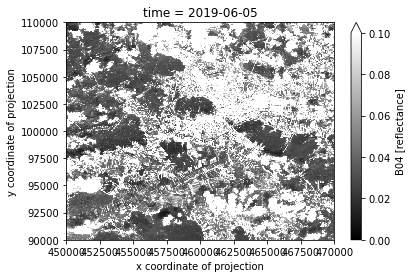

In [7]:
cube.B04.isel(time=17).plot.imshow(cmap='gray', vmin=0, vmax=0.1)

Get the DCFS GeoDB service, please configure this according to your user credentials:

In [10]:
geodb=GeoDBClient()

The current user's feature collections:

In [11]:
geodb.whoami

'geodb_ci_test_user'

Take a look at the existing collections

In [12]:
geodb.get_my_collections()

,owner,database,table_name
0,geodb_9bfgsdfg-453f-445b-a459,geodb_9bfgsdfg-453f-445b-a459,land_use
1,tt,tt,tt300


Add a collection:

In [13]:
ds = geodb.get_my_collections()

if ds[(ds.database == geodb.whoami) & (ds.table_name == 'land_use')].table_name.count() == 0:
    # Have a look at fiona feature schema
    collections = {
            "land_use": 
            {
                "crs": 3794,
                "properties": 
                {
                    "RABA_PID": "float", 
                    "RABA_ID": "float", 
                    "D_OD": "date"
                }
            }
        }


    geodb.create_collections(collections)
    import geopandas
    import os
    gdf = geopandas.read_file(os.path.expanduser("../data/land_use/land_use.shp"))
    geodb.insert_into_collection('land_use', gdf)

Processing rows from 0 to 9827


Check if 'land_use' has been added to our collections

In [14]:
geodb.get_my_collections()

,owner,database,table_name
0,geodb_9bfgsdfg-453f-445b-a459,geodb_9bfgsdfg-453f-445b-a459,land_use
1,geodb_ci_test_user,geodb_ci_test_user,land_use
2,tt,tt,tt300


Find features in collection `land_use` for our bounding box:

In [15]:
features = geodb.get_collection_by_bbox(collection='land_use', bbox=bbox_3794, bbox_crs=3794)

Take a look at the features:

In [16]:
features

,id,created_at,modified_at,geometry,raba_pid,raba_id,d_od
0,1,2021-02-03T13:55:58.974445+00:00,None,"POLYGON ((453952.629 91124.177, 453952.696 911...",4770326,1410,2019-03-26
1,2,2021-02-03T13:55:58.974445+00:00,None,"POLYGON ((453810.376 91150.199, 453812.552 911...",4770325,1300,2019-03-26
2,3,2021-02-03T13:55:58.974445+00:00,None,"POLYGON ((456099.635 97696.070, 456112.810 976...",2305689,7000,2019-02-25
3,4,2021-02-03T13:55:58.974445+00:00,None,"POLYGON ((455929.405 97963.785, 455933.284 979...",2305596,1100,2019-02-25
4,5,2021-02-03T13:55:58.974445+00:00,None,"POLYGON ((461561.512 96119.256, 461632.114 960...",2310160,1100,2019-03-11
...,...,...,...,...,...,...,...
9820,9823,2021-02-03T13:55:58.974445+00:00,None,"POLYGON ((460637.334 96865.891, 460647.927 969...",6253989,1600,2019-03-08
9821,9824,2021-02-03T13:55:58.974445+00:00,None,"POLYGON ((459467.868 96839.686, 459467.770 968...",6252044,1600,2019-03-26
9822,9825,2021-02-03T13:55:58.974445+00:00,None,"POLYGON ((459488.998 94066.248, 459498.145 940...",6245985,2000,2019-04-08
9823,9826,2021-02-03T13:55:58.974445+00:00,None,"POLYGON ((459676.680 94000.000, 459672.469 939...",6245986,2000,2019-02-20


Rasterise feature properties into cube:

In [17]:
cube2 = rasterize_features(cube, features, ['raba_id'])

In [18]:
cube2

<xarray.Dataset>
Dimensions:    (bnds: 2, time: 31, x: 512, y: 512)
Coordinates:
  * time       (time) datetime64[ns] 2019-05-02 2019-05-04 ... 2019-07-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
  * x          (x) float64 4.5e+05 4.501e+05 4.501e+05 ... 4.699e+05 4.7e+05
  * y          (y) float64 1.1e+05 1.099e+05 1.099e+05 ... 9.006e+04 9.002e+04
Dimensions without coordinates: bnds
Data variables:
    raba_id    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-02-03T14:54:38.745414
    processing_level:          L2A
    time_coverage_start:       2019-05-01T00:00:00+00:00
    time_coverage_end:         2019-07-02T00:00:00+00:00
    time_coverage_duration:    P62DT0H0M0S
    time_coverage_resolution:  P2DT0H0M0S

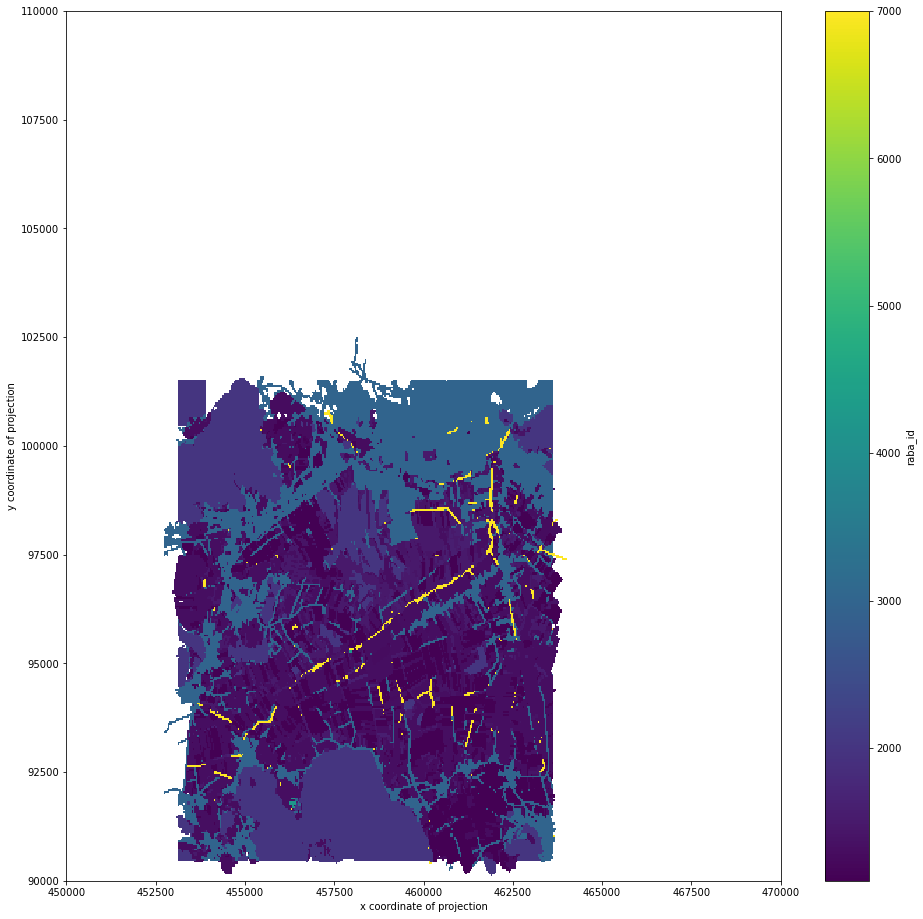

In [19]:
cube2.raba_id.plot.imshow(figsize=(16, 16))

Finally, drop the collection

In [20]:
geodb.drop_collection('land_use')


Collection ['geodb_ci_test_user_land_use'] deleted

Make sure, the collection does not exist anymore:

In [21]:
geodb.get_my_collections()

,owner,database,table_name
0,geodb_9bfgsdfg-453f-445b-a459,geodb_9bfgsdfg-453f-445b-a459,land_use
1,tt,tt,tt300
